# Setup code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/projet/VOC2012/JPEGImages/
!ls
%cd /content/drive/My Drive/projet/SynthOldPhotos/
!ls
# %cd projet
# !ls VOC2012
# !rm -rf VOC2012/Annotations
# !rm -rf voc2012
# !rm -rf SynthOldPhotos/
# !unzip SynthOldPhotos.zip
# !unzip pascal.zip
# !pwd


Streaming output truncated to the last 5000 lines.
2008_005664.jpg  2010_000067.jpg  2011_001596.jpg  2012_002926.jpg
2008_005668.jpg  2010_000069.jpg  2011_001597.jpg  2012_002928.jpg
2008_005673.jpg  2010_000071.jpg  2011_001599.jpg  2012_002933.jpg
2008_005675.jpg  2010_000072.jpg  2011_001600.jpg  2012_002935.jpg
2008_005676.jpg  2010_000073.jpg  2011_001601.jpg  2012_002936.jpg
2008_005677.jpg  2010_000074.jpg  2011_001602.jpg  2012_002937.jpg
2008_005678.jpg  2010_000075.jpg  2011_001605.jpg  2012_002939.jpg
2008_005679.jpg  2010_000076.jpg  2011_001606.jpg  2012_002941.jpg
2008_005680.jpg  2010_000079.jpg  2011_001607.jpg  2012_002942.jpg
2008_005681.jpg  2010_000080.jpg  2011_001608.jpg  2012_002943.jpg
2008_005682.jpg  2010_000082.jpg  2011_001610.jpg  2012_002944.jpg
2008_005683.jpg  2010_000083.jpg  2011_001611.jpg  2012_002945.jpg
2008_005685.jpg  2010_000084.jpg  2011_001612.jpg  2012_002949.jpg
2008_005686.jpg  2010_000085.jpg  2011_001613.jpg  2012_002952.jpg
2008_005687

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import PIL.Image
from matplotlib import pyplot as plt
torch.manual_seed(1)
torch.cuda.manual_seed(1)
import tqdm
from torchsummary import summary
from torch.nn import init
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock # ResNet Block

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Y_path = "/content/drive/My Drive/projet/VOC2012/JPEGImages/"
X_path = "/content/drive/My Drive/projet/SynthOldPhotos/"
vae1_path = "/content/drive/My Drive/projet/model_VAE1.h5"
vae2_path = "/content/drive/My Drive/projet/model_VAE2.h5"
batch_size = 16 # What ever fit into gpu memory

# Data Loader / Data set

In [ ]:
class XYPhotosDataset(Dataset):
    def __init__(self, y_path,x_path):
        self.x_files = [os.path.join(y_path, f) for f in sorted(os.listdir(x_path))]
        self.y_files = [os.path.join(x_path, f) for f in sorted(os.listdir(y_path))]

    def __getitem__(self, index):
        img_y=self.Read_image(self.y_files[index]);
        img_x=self.Read_image(self.x_files[index]);
        return img_y,img_x

    def Read_image(self,name):
        img = PIL.Image.open(name).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img)/255.0;
        img=np.transpose(img,(2,0,1)).astype('float32')
        return torch.tensor(img-0.5)

    def __len__(self):
      return min([len(self.y_files),len(self.x_files)])   # Need a better way, might not use some part of the data

# test data gen
data_set = XYPhotosDataset(Y_path, X_path)
img1,img2=data_set.__getitem__(0);


train_len = int(len(data_set)*0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False,num_workers=5)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=5)

# Model Classes

In [ ]:
class Mapping(nn.Module):
    def __init__(self, z_dim=256):
        """
        Initialize the model structure following the paper
        """
        super(Mapping, self).__init__()
        # self.dim_reshape = int(np.sqrt(z_dim))
        # Using InstanceNorm2D since it seems that is what is preferred in the paper (for facial enhancement, but still).

        # First 3 conv2d layers 
        self.conv1 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 256, 3, stride=1, padding=1), 
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU(), 
                                    nn.Conv2d(256, 512, 3, stride=1, padding=1), 
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU()
                                    )
        
        # ResNet Blocks x 6
        self.resblocks = nn.Sequential(BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                        BasicBlock(512, 512),
                                        nn.InstanceNorm2d(64),
                                       )
        
        # Second batch of conv2d layer 
        self.conv2 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1),
                            nn.InstanceNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(256, 128, 3, stride=1, padding=1), 
                            nn.InstanceNorm2d(64),
                            nn.ReLU(), 
                            nn.Conv2d(128, 64, 3, stride=1, padding=1), 
                            nn.InstanceNorm2d(64),
                            nn.ReLU()
                            )
        
    def forward(self, x):
        """
        Execute forward pass in the model

        Args:
            x (array-like): input of the model (here, latent space generated by VAE1 (union of Zx and Zr)) 
            Input shape: torch.Size([10, 1, 256])

        Returns:
            array-like: translated latent space to Zy
        """
        out = x
        out = self.conv1(out)
        out = self.resblocks(out)
        out = self.conv2(out)
        return out



In [ ]:
# Discriminator
class ConvBNRelu(nn.Module):
    def __init__(self, nin,nout,stride=2):
        super(ConvBNRelu, self).__init__()
        self.layer=nn.Sequential(nn.Conv2d(in_channels = nin,out_channels = nout,kernel_size = 4,stride = stride,padding = 1,bias = False),
                  nn.BatchNorm2d(nout),
                  nn.LeakyReLU(0.2, inplace=True))
    def forward(self, x):
        return self.layer(x);


class Discriminator(nn.Module):
    def __init__(self,nChannels=64, ndf=64):
        super(Discriminator, self).__init__()
        # input : (batch * nChannels * image width * image height)
        # Discriminator will be consisted with a series of convolution networks
        self.ndf = ndf
        self.layer1 = ConvBNRelu(nChannels,ndf,stride=2); 
        self.layer2 =  ConvBNRelu(ndf,ndf*2,stride=2); 
        self.layer3 =  ConvBNRelu(ndf*2,ndf*4,stride=2); 
        self.layer4 =  ConvBNRelu(ndf*4,ndf*8,stride=2); 
        self.layer5 =   ConvBNRelu(ndf*8,1,stride=1); 
        self.final = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size = 1,stride = 1)

        self.layers = [self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.final]

    def forward(self, x):
        out = self.layer1(x);
        out = self.layer2(out);
        out = self.layer3(out);
        out = self.layer4(out)
        out = self.layer5(out);
        out = self.final(out);
        return out

    def compute_perceptual_loss(self, input, target):
        x = input
        y = target
        loss = 0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += torch.nn.functional.l1_loss(x, y)

        return loss


# PERCEPTUAL LOSS FOR VGG
# source : https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [ ]:
class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out

class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));



class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));

class VAE1_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=5):
        super(VAE1_encoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.layer1 = ConvBNR(in_channels,64,kw=7,pad=3,strides=1);
        for j in range(n_layers):
            self.layer.append(ConvBNR(64,64));

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        return x

class VAE1_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=5):
        super(VAE1_decoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));

        #self.layer1 = TransposeConvBNR(64,out_channel,kw=7,pad=3,strides=1,activation=None);
        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1);
        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        
        for j in range(self.n_layers):
           # print(x.shape)
            x= self.layer[j](x)
        #print(x.shape)
        x=self.layer1(x);
        return x

class VAE1(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE1, self).__init__()
        self.n_layers=2;
        self.down_fact=2**self.n_layers;
        down_img_size=256//self.down_fact;
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE1_encoder(n_layers=self.n_layers)
        self.decoder=VAE1_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)
        #self.init_weights();

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar*1e-3; #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img=self.unflat(z);
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x,flow='all'):
      z_latent, mu, logvar = self.encode(x)
      z,z_out = self.decode(z_latent)
      if(flow=='all'):
        return z, mu, logvar,z_out
      else:
        return z, mu, logvar,z_out,z_latent



In [ ]:
class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1);
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out

class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));



class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad);
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)));

class VAE2_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=5):
        super(VAE2_encoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        self.layer1 = ConvBNR(in_channels,64,kw=7,pad=3,strides=1);
        for j in range(n_layers):
            self.layer.append(ConvBNR(64,64));

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        return x

class VAE2_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=5):
        super(VAE2_decoder, self).__init__()
        self.n_layers=n_layers;
        self.layer=nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));

        #self.layer1 = TransposeConvBNR(64,out_channel,kw=7,pad=3,strides=1,activation=None);
        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1);
        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks;
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x);
        
        for j in range(self.n_layers):
           # print(x.shape)
            x= self.layer[j](x)
        #print(x.shape)
        x=self.layer1(x);
        return x

class VAE2(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE2, self).__init__()
        self.n_layers=2;
        self.down_fact=2**self.n_layers;
        down_img_size=256//self.down_fact;
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE2_encoder(n_layers=self.n_layers)
        self.decoder=VAE2_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)
        #self.init_weights();

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar*1e-3; #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img=self.unflat(z);
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x,flow='all'):
      z_latent, mu, logvar = self.encode(x)
      z,z_out = self.decode(z_latent)
      if(flow=='all'):
        return z, mu, logvar,z_out
      else:
        return z, mu, logvar,z_out,z_latent

# Training / Testing code

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


bottle neck image resolution 64
bottle neck dim is 262144..!
bottle neck image resolution 64
bottle neck dim is 262144..!






Training model...:   0%|          | 0/100 [00:00<?, ?it/s]




Testing model...: 0it [00:00, ?it/s]

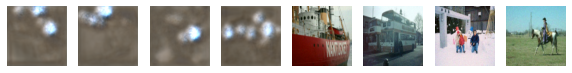






Testing model...: 1it [00:03,  3.37s/it]




Testing model...: 2it [00:04,  2.61s/it]




Testing model...: 3it [00:05,  2.08s/it]




Testing model...: 4it [00:05,  1.71s/it]




Testing model...: 5it [00:06,  1.45s/it]




Testing model...: 6it [00:07,  1.27s/it]




Testing model...: 7it [00:08,  1.14s/it]




Testing model...: 8it [00:09,  1.05s/it]




Testing model...: 9it [00:10,  1.01it/s]




Testing model...: 10it [00:10,  1.06it/s]




Testing model...: 11it [00:11,  1.09it/s]




Testing model...: 12it [00:12,  1.12it/s]




Testing model...: 13it [00:13,  1.14it/s]




Testing model...: 14it [00:14,  1.15it/s]




Testing model...: 15it [00:15,  1.16it/s]




Testing model...: 16it [00:20,  2.30s/it]




Testing model...: 17it [00:24,  2.62s/it]




Testing model...: 18it [00:25,  2.09s/it]




Testing model...: 19it [00:25,  1.72s/it]




Testing model...: 20it [00:26,  1.45s/it]




Testing model...: 21it [00:33,  3.11s/it]




Testing model...: 22it [00:37,  3.33s/

====> Test set loss_mapping: 3.3426






Training model...:   1%|          | 1/100 [04:18<7:06:06, 258.25s/it]




Testing model...: 0it [00:00, ?it/s]




Testing model...: 1it [00:02,  2.17s/it]




Testing model...: 2it [00:03,  1.78s/it]




Testing model...: 3it [00:03,  1.50s/it]




Testing model...: 4it [00:04,  1.30s/it]




Testing model...: 5it [00:05,  1.17s/it]




Testing model...: 6it [00:06,  1.07s/it]




Testing model...: 7it [00:07,  1.01s/it]




Testing model...: 8it [00:08,  1.04it/s]




Testing model...: 9it [00:09,  1.07it/s]




Testing model...: 10it [00:09,  1.10it/s]




Testing model...: 11it [00:10,  1.12it/s]




Testing model...: 12it [00:11,  1.13it/s]




Testing model...: 13it [00:12,  1.14it/s]




Testing model...: 14it [00:13,  1.15it/s]




Testing model...: 15it [00:14,  1.15it/s]




Testing model...: 16it [00:15,  1.15it/s]




Testing model...: 17it [00:15,  1.15it/s]




Testing model...: 18it [00:16,  1.16it/s]




Testing model...: 19it [00:17,  1.15it/s]




Testing model...

====> Test set loss_mapping: 3.3422






Training model...:   2%|▏         | 2/100 [05:55<5:43:02, 210.03s/it]




Testing model...: 0it [00:00, ?it/s]




Testing model...: 1it [00:02,  2.26s/it]




Testing model...: 2it [00:03,  1.86s/it]




Testing model...: 3it [00:04,  1.58s/it]




Testing model...: 4it [00:05,  1.38s/it]




Testing model...: 5it [00:05,  1.24s/it]




Testing model...: 6it [00:06,  1.15s/it]




Testing model...: 7it [00:07,  1.08s/it]




Testing model...: 8it [00:08,  1.03s/it]




Testing model...: 9it [00:09,  1.01it/s]




Testing model...: 10it [00:10,  1.03it/s]




Testing model...: 11it [00:11,  1.04it/s]




Testing model...: 12it [00:12,  1.05it/s]




Testing model...: 13it [00:13,  1.06it/s]




Testing model...: 14it [00:14,  1.07it/s]




Testing model...: 15it [00:15,  1.07it/s]




Testing model...: 16it [00:16,  1.07it/s]




Testing model...: 17it [00:17,  1.07it/s]




Testing model...: 18it [00:17,  1.08it/s]




Testing model...: 19it [00:18,  1.08it/s]




Testing model...

====> Test set loss_mapping: 3.3404






Training model...:   3%|▎         | 3/100 [07:37<4:47:00, 177.53s/it]




Testing model...: 0it [00:00, ?it/s]




Testing model...: 1it [00:02,  2.26s/it]




Testing model...: 2it [00:03,  1.87s/it]




Testing model...: 3it [00:04,  1.58s/it]




Testing model...: 4it [00:05,  1.38s/it]




Testing model...: 5it [00:05,  1.25s/it]




Testing model...: 6it [00:06,  1.15s/it]




Testing model...: 7it [00:07,  1.09s/it]




Testing model...: 8it [00:08,  1.04s/it]




Testing model...: 9it [00:09,  1.01s/it]




Testing model...: 10it [00:10,  1.01it/s]




Testing model...: 11it [00:11,  1.03it/s]




Testing model...: 12it [00:12,  1.04it/s]




Testing model...: 13it [00:13,  1.05it/s]




Testing model...: 14it [00:14,  1.06it/s]




Testing model...: 15it [00:15,  1.06it/s]




Testing model...: 16it [00:16,  1.07it/s]




Testing model...: 17it [00:17,  1.07it/s]




Testing model...: 18it [00:18,  1.07it/s]




Testing model...: 19it [00:19,  1.07it/s]




Testing model...

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1ca239a72123>", line 96, in <module>
    Y_y_y, _, _, _ = vae2(sample_y)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "<ipython-input-8-d4558d7447ad>", line 175, in forward
    z_latent, mu, logvar = self.encode(x)
  File "<ipython-input-8-d4558d7447ad>", line 165, in encode
    z, mu, logvar = self.bottleneck(h)
  File "<ipython-input-8-d4558d7447ad>", line 159, in bottleneck
    z = self.reparameterize(mu, logvar)
  File "<ipython-input-8-d4558d7447ad>", line 152, in reparameterize
    esp = torch.randn(*mu.size()).to(device)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/loca

KeyboardInterrupt: ignored

<Figure size 720x576 with 0 Axes>

In [ ]:
vgg = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True).to(device)
# torch.autograd.set_detect_anomaly(True)


lambda_1 = 60
lambda_2 = 10
learning_rate = 1e-4

save_dir = "/content/drive/My Drive/projet/"


disc = Discriminator(nChannels=3,ndf=64).to(device)
vae1 = VAE1()
vae2 = VAE2().to(device)
vae1_state_dict = torch.load(vae1_path)
vae2_state_dict = torch.load(vae2_path)
vae1.load_state_dict(vae1_state_dict)
vae2.load_state_dict(vae2_state_dict)
vae1_enc_net = vae1.encoder.to(device)

for param in vae1.parameters():
    param.requires_grad = False
for param in vae2.parameters():
    param.requires_grad = False
for param in vae1_enc_net.parameters():
    param.requires_grad = False

vae1.eval()
vae2.eval()
vae1_enc_net.eval()

mapping_net = Mapping().to(device)

# Aucune indication sur comment train le discriminant, donc on y va comme cela
optim_mapping = torch.optim.Adam(list(mapping_net.parameters()) + list(disc.parameters()), lr=learning_rate, betas=(0.5, 0.999))

epochs = 100

mae_loss = nn.L1Loss().to(device)
perceptual_loss = VGGPerceptualLoss().to(device)
for epoch in tqdm.tqdm(range(0, epochs), desc="Training model..."):
    mapping_net.train()
    disc.train()
    for sample_y, sample_x in tqdm.tqdm(train_loader, desc=f"Currently on epoch {epoch}, training"):
        sample_y = sample_y.to(device)
        sample_x = sample_x.to(device)

        # Prendre image synthethique, envoyer dans VAE1 encodeur (donne Z_x)
        Z_x = vae1_enc_net(sample_x)
        # Prendre image encodee (Z_x), envoyer dans le mapping (donne Z_x->y)
        Z_x_y = mapping_net(Z_x)
        # Prendre la traduction (Z_x->y), l'envoyer dans le G_y (donne X_x->y)
        X_x_y = vae2.decoder(Z_x_y)
        # Prendre l'image originale, l'envoyer dans l'encodeur de VAE 2 pour obtenir Z_y
        Z_y = vae2.encoder(sample_y)
        # Prendre l'image originale (y), la passer dans VAE2 (donne Y_y->y)
        Y_y_y, _, _, _ = vae2(sample_y)

        # COMPUTE LOSSES
        # Calculer l1_loss avec Zx->y et Zy
        l1loss = mae_loss(Z_x_y, Z_y)
        # Calculer la LSGAN Loss 
        lsgan_loss = torch.mean(disc(X_x_y)**2) + torch.mean(1 - disc(Y_y_y)**2)
        # Calculer la FM loss
        vgg_loss = perceptual_loss(X_x_y, Y_y_y)
        disc_perc_loss = disc.compute_perceptual_loss(X_x_y, Y_y_y)
        fm_loss = torch.mean(disc_perc_loss + vgg_loss)

        mapping_loss = lambda_1 * l1loss + lsgan_loss + lambda_2 * fm_loss
        
        # Faire backward et step, reinitialiser le gradient.
        optim_mapping.zero_grad()
        mapping_loss.backward()
        optim_mapping.step()

    print(f'====> Epoch: {epoch} Average mapping loss: {mapping_loss / len(train_loader.dataset):.4f}')

    with torch.no_grad():
        mapping_net.eval()
        disc.eval()
        test_loss_mapping = 0
        test_loss_disc = 0
        for ix,(sample_y, sample_x) in tqdm.tqdm(enumerate(test_loader), desc="Testing model..."):
            sample_y = sample_y.to(device)
            sample_x = sample_x.to(device)
            
            # Prendre image synthethique, envoyer dans VAE1 encodeur (donne Z_x)
            Z_x=vae1_enc_net(sample_x);
            # Prendre image encodee (Z_x), envoyer dans le mapping (donne Z_x->y)
            Z_x_y = mapping_net(Z_x)
            # Prendre la traduction (Z_x->y), l'envoyer dans le G_y (donne X_x->y)
            X_x_y = vae2.decoder(Z_x_y)
            # Prendre l'image originale, l'envoyer dans l'encodeur de VAE 2 pour obtenir Z_y
            Z_y = vae2.encoder(sample_y)
            # Prendre l'image originale (y), la passer dans VAE2 (donne Y_y->y)
            Y_y_y, _, _, _ = vae2(sample_y)

            # COMPUTE LOSSES
            # Calculer l1_loss avec Zx->y et Zy
            l1loss = mae_loss(Z_x_y, Z_y)
            # Calculer la LSGAN Loss 
            lsgan_loss = torch.mean(disc(X_x_y)**2) + torch.mean(1 - disc(Y_y_y)**2)
            # Calculer la FM loss
            vgg_loss = perceptual_loss(X_x_y, Y_y_y)
            disc_loss = disc.compute_perceptual_loss(X_x_y, Y_y_y)

            fm_loss = torch.mean(disc_loss + vgg_loss)

            mapping_loss = lambda_1 * l1loss + lsgan_loss + lambda_2 * fm_loss

            test_loss_mapping += mapping_loss.item();


            if(ix<1 and epoch%5==0):
              plt.figure(figsize=(10, 8))
              #plt.suptitle('real test data / reconstructions')
              for i in range(4):
                  plt.subplot(1,8,i+1)
                  plt.imshow(np.clip(X_x_y.detach().cpu().numpy()[i,:,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1,8,i+1+4)
                  plt.imshow(np.clip(sample_y.detach().cpu().numpy()[i,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')
              plt.show()

              plt.figure(figsize=(10, 8))

    test_loss_mapping /= len(test_loader.dataset)
    print(f'====> Test set loss_mapping: {test_loss_mapping:.4f}')
    print(f"Saving model for epoch {epoch}")
    torch.save(mapping_net.state_dict(), save_dir + f"mapping_{epoch}_testloss_{test_loss_mapping}.h5")
    torch.save(disc.state_dict(), save_dir + f"discriminator_{epoch}_testloss_{test_loss_mapping}.h5")